# Final Project (Churn Prediction)
###### Estefania Perez & Daniel Cruz 

### 1. Data Preprocessing

In [1]:
#%pip install xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# EDA Summary of Churn_Modeling Dataset
churn_data = pd.read_csv('Churn_Modelling.csv')

print("Dataset Info:")
print(churn_data.info())
print("\n")

print("First 5 rows:")
print(churn_data.head())
print("\n")

print("Dataset Shape:")
print(f"{churn_data.shape[0]} rows, {churn_data.shape[1]} columns\n")

print("Chrun Value Counts:")
print(churn_data['Exited'].value_counts())
print("\n")
print(f"Chrun Percentage:\n {churn_data['Exited'].value_counts(normalize=True) * 100}")

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None


First 5 rows:
   RowNumber  CustomerId   Surname  CreditScore Geography  

In [3]:
'''
Cleaning/Preparing The Chrun Data
- Dropping Irrelevant Columns
- Encoding Categorical Variables
- Splitting into Train/Test Sets (80/20)
'''

#dropping irrelevant columns (RowNumber, CustomerId, Surname)
churn_data = churn_data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

#Encoding Categorical Variables (Gender (Binary Encoding) and Geography(One-hot encoding))
churn_data['Gender'] = churn_data['Gender'].map({'Female': 0, 'Male':1})
#Need to elaborate why we used get_dummies and drop_first
churn_data = pd.get_dummies(churn_data, columns = ['Geography'], drop_first=True)
print("Data is now Encoded Properly:")
print(churn_data.head())


#False, False = France
#True, False = Germany
#False, True = Spain

Data is now Encoded Properly:
   CreditScore  Gender  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          619       0   42       2       0.00              1          1   
1          608       0   41       1   83807.86              1          0   
2          502       0   42       8  159660.80              3          1   
3          699       0   39       1       0.00              2          0   
4          850       0   43       2  125510.82              1          1   

   IsActiveMember  EstimatedSalary  Exited  Geography_Germany  Geography_Spain  
0               1        101348.88       1              False            False  
1               1        112542.58       0              False             True  
2               0        113931.57       1              False            False  
3               0         93826.63       0              False            False  
4               1         79084.10       0              False             True  


In [4]:
# Train-Test Split
from sklearn.model_selection import train_test_split

#Seperating features and target
X = churn_data.drop('Exited', axis=1)
y = churn_data['Exited']

#Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, stratify = y, random_state = 42
)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train class distribution:\n", y_train.value_counts(normalize=True))
print("y_test class distribution:\n", y_test.value_counts(normalize=True))

X_train shape: (8000, 11)
X_test shape: (2000, 11)
y_train class distribution:
 Exited
0    0.79625
1    0.20375
Name: proportion, dtype: float64
y_test class distribution:
 Exited
0    0.7965
1    0.2035
Name: proportion, dtype: float64


### 2. Model Design and Training

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

#Standardizing the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Decision Tree
print("Decision Tree:")
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("-" * 50)

#SVM
print("Support Vector Machine (SVM):")
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm)}")
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))
print("-" * 50)

#MLP
print("MLP Classifier:")
mlp_model = MLPClassifier(random_state=42, max_iter=300)
mlp_model.fit(X_train, y_train)
y_pred_mlp = mlp_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_mlp)}")
print("Classification Report:")
print(classification_report(y_test, y_pred_mlp))
print("-" * 50)

# Logistic Regression
print("Logistic Regression:")
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr)}")
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))
print("-" * 50)

Decision Tree:
Accuracy: 0.786
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86      1593
           1       0.48      0.52      0.50       407

    accuracy                           0.79      2000
   macro avg       0.68      0.69      0.68      2000
weighted avg       0.79      0.79      0.79      2000

--------------------------------------------------
Support Vector Machine (SVM):
Accuracy: 0.861
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      1593
           1       0.83      0.40      0.54       407

    accuracy                           0.86      2000
   macro avg       0.85      0.69      0.73      2000
weighted avg       0.86      0.86      0.84      2000

--------------------------------------------------
MLP Classifier:
Accuracy: 0.862
Classification Report:
              precision    recall  f1-score   support

           

/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [6]:
#Utilizing ensemble methods Bagging and Random Forest, XGBoost
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

# Bagging with Decision Tree
print("Bagging Classifier (with Decision Tree):")
bag_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=10,
    random_state=42
)
bag_model.fit(X_train, y_train)
y_pred_bag = bag_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_bag)}")
print("Classification Report:")
print(classification_report(y_test, y_pred_bag))
print("-" * 50)

#Random Forest
print("Random Forest Classifier:")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("-" * 50)


# XGBoost Classifier
print("XGBoost Classifier:")
xgb_model = XGBClassifier(
    eval_metric='logloss',  
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb)}")
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("-" * 50)

Bagging Classifier (with Decision Tree):
Accuracy: 0.853
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1593
           1       0.71      0.46      0.56       407

    accuracy                           0.85      2000
   macro avg       0.79      0.71      0.74      2000
weighted avg       0.84      0.85      0.84      2000

--------------------------------------------------
Random Forest Classifier:
Accuracy: 0.861
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.92      1593
           1       0.76      0.46      0.57       407

    accuracy                           0.86      2000
   macro avg       0.82      0.71      0.75      2000
weighted avg       0.85      0.86      0.85      2000

--------------------------------------------------
XGBoost Classifier:
Accuracy: 0.849
Classification Report:
              precision    recall  f1-sc

MLP Classifier:
Accuracy: 0.862
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1593
           1       0.75      0.48      0.59       407

    accuracy                           0.86      2000
   macro avg       0.81      0.72      0.75      2000
weighted avg       0.85      0.86      0.85      2000

--------------------------------------------------


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


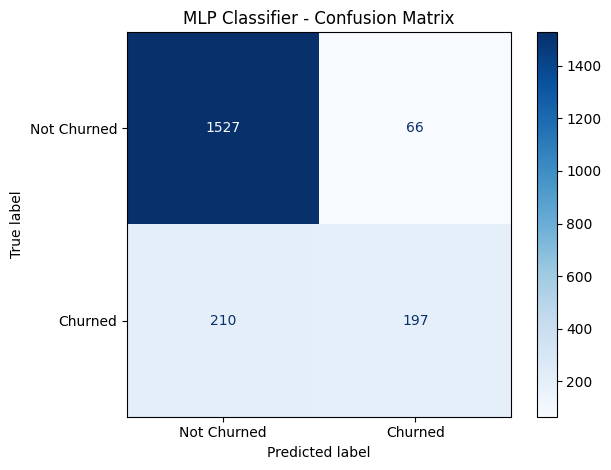

In [7]:
'''
After reviewing all of the classification algorithms it seems that MLP is the "best one" so we will be using
that model to train our dataset.
'''
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

print("MLP Classifier:")
mlp_model = MLPClassifier(random_state=42, max_iter=300)
mlp_model.fit(X_train, y_train)
y_pred_mlp = mlp_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_mlp)}")
print("Classification Report:")
print(classification_report(y_test, y_pred_mlp))
print("-" * 50)

# Plot Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    mlp_model, X_test, y_test,
    display_labels=["Not Churned", "Churned"],
    cmap=plt.cm.Blues,
    values_format='d'
)
plt.title("MLP Classifier - Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()


### 3. Model Improvements

#### Hyperparamter Tuning

In [18]:
from sklearn.model_selection import GridSearchCV

#source that helped: https://michael-fuchs-python.netlify.app/2021/02/03/nn-multi-layer-perceptron-classifier-mlpclassifier/
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (50, 100), (100, 50)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'adaptive']
}

grid_search = GridSearchCV(mlp_model, param_grid, n_jobs=-1, cv=3, verbose=2)
grid_search.fit(X_train, y_train)

grid_pred = grid_search.predict(X_test)

print("Best Hyperparameters: ", grid_search.best_params_)
print("Accuracy: ", accuracy_score(y_test, grid_pred))
print("Classification Report:")
print(classification_report(y_test, grid_pred))

Fitting 3 folds for each of 180 candidates, totalling 540 fits


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maxim

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   1.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maxim

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   3.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   3.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   3.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   3.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   3.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   3.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maxim

[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   3.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   3.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   3.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   3.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   3.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   3.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   3.8s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   4.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   4.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   4.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   3.8s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   3.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   3.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   5.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   5.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   5.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   5.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   5.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   5.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   5.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   5.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   5.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   5.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   5.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   5.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   5.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   5.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   5.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   5.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   5.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   5.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   5.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   5.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   5.0s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   5.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   5.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   4.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.1s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.1s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.1s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   3.3s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   3.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maxim

[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   3.0s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   3.0s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   3.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   3.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   3.1s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   3.0s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   3.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   3.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.0s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   3.8s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   3.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   4.1s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   4.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   3.8s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   3.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   3.8s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   4.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   5.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   5.6s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   5.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   5.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   5.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   5.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   5.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   5.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   5.6s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   5.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   5.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   5.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   5.6s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   5.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   5.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   5.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   5.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   5.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   5.8s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   5.1s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   5.9s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   1.3s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   5.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   5.8s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   5.3s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   1.2s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maxim

[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.2s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.3s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.2s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.1s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.2s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.1s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   3.2s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   3.2s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   3.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   3.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   3.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   3.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.2s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   3.1s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   3.1s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   3.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.3s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   3.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   3.9s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   4.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   4.0s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   4.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   4.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   3.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   4.0s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   3.9s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   5.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   5.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   5.5s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   5.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   5.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   5.4s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   5.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   5.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   5.3s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   5.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   5.2s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   5.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   5.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   5.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   5.5s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   5.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   5.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   5.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   5.4s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   5.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   5.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.4s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   5.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   0.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   5.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.5s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   5.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maxim

[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.2s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   0.9s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   0.9s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   0.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   0.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   3.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   3.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   3.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   1.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.2s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   4.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   4.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   4.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   4.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   4.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   4.2s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   4.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   4.2s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   4.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   5.8s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   5.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   5.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   6.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   5.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   5.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   5.8s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   6.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   6.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   5.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   5.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   5.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   5.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   5.8s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   5.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   5.8s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   5.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   5.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   6.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   5.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   0.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   0.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   5.1s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   5.8s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   5.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   0.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   5.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   0.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   0.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   0.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.3s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   0.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   1.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   3.3s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   3.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   3.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   1.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   4.1s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   4.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   4.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   4.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   4.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   4.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   4.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   4.1s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   4.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   6.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   6.1s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   5.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   6.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   5.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   5.8s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   6.2s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   6.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   6.2s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   5.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   5.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   5.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   6.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   6.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   6.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   6.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   6.0s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   6.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   6.3s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   6.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   0.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   1.8s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   5.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   6.1s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   5.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   5.5s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   0.8s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   0.9s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   1.9s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   0.9s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.2s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.1, hidden

/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.3s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   3.2s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   3.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   1.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   3.5s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.1s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.5s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   3.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   4.3s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.5s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   3.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   4.2s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   4.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   4.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   4.5s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   2.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   4.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   4.2s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   4.3s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   4.5s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   5.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   5.5s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   2.8s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   4.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   5.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   5.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   5.3s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   6.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   5.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   5.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   5.8s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   5.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   5.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   6.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   5.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   5.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   5.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   5.7s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   5.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.8s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   5.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   5.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   5.4s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.1s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.8s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.7s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.8s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.7s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.4s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.5s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   4.1s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   4.1s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   3.0s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   3.2s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   3.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   4.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   4.1s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   4.1s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   0.3s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   0.2s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   0.2s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   3.9s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   4.1s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time

/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   3.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.6s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   1.1s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   1.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.6s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   1.1s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   0.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.8s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   0.3s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   0.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   4.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   4.9s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   5.1s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   1.4s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   1.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   6.4s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   6.3s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   1.4s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   0.3s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   6.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   0.4s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   0.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   6.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   6.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   6.5s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   1.6s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   1.6s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   6.1s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   1.5s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   5.3s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   5.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   6.5s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   6.1s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.7s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   6.3s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.6s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.7s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.4s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.5s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   4.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   4.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   3.1s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   3.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   3.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   4.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   4.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   4.2s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   0.2s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   0.3s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   0.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   4.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   3.7s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   3.9s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   3.5s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   4.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   1.1s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   1.1s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   1.1s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   0.4s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   0.3s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   0.3s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.8s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   3.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   4.8s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   4.9s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   1.5s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   1.5s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   1.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   6.4s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   6.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   6.4s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   0.4s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   0.4s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   0.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   6.3s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   6.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   6.4s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   1.5s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   1.5s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   4.9s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   5.9s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   1.5s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   5.0s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam

/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   4.8s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.4s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.1s
[CV] END activation=logistic, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   5.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.6s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.0s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.5s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.4s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.5s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.4s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.5s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   3.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   3.7s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   3.0s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   3.1s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   3.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   3.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.8s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   0.3s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   0.3s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   0.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.9s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   2.6s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   4.0s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   4.1s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   4.0s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   2.5s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   1.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.5s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   1.0s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   1.1s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   0.3s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   0.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.5s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   0.3s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   2.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   4.7s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   4.6s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   2.9s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   3.3s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   2.6s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   2.8s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   1.5s
[CV] END activation=logistic, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total t

/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
#https://sklearner.com/scikit-learn-random-search-mlpclassifier/

param_grid = {'hidden_layer_sizes': [(50,), (100,), (50, 50), (50, 100), (100, 50)],
              'activation': ['relu', 'tanh'],
              'solver': ['adam', 'sgd'],
              'alpha': [0.001, 0.01, 0.1],
              'learning_rate': ['constant', 'adaptive']}

random_search = RandomizedSearchCV(mlp_model, param_distributions=param_grid, n_iter=105, n_jobs=-1, cv=5, verbose=2)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
acc = best_model.score(X_test, y_test)
#print("Best hyperparameters: ", random_search.best_params_)
#print("Accuracy: " + str(acc))
#print("Classification Report:")
#print(classification_report(y_test, best_model.predict(X_test)))

with open('output.txt', 'w') as f: #output is more than 500 lines and wont show properly
    print("Best hyperparameters: ", random_search.best_params_, file=f)
    print("Accuracy: " + str(acc), file=f)
    print("Classification Report:", file=f)
    print(classification_report(y_test, best_model.predict(X_test)), file=f)

"""
Output from the file during the last run was:

Best hyperparameters:  {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'alpha': 0.1, 'activation': 'tanh'}
Accuracy: 0.8695
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1593
           1       0.77      0.51      0.61       407

    accuracy                           0.87      2000
   macro avg       0.83      0.73      0.77      2000
weighted avg       0.86      0.87      0.86      2000
"""

Fitting 5 folds for each of 105 candidates, totalling 525 fits
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   0.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   0.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   0.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   5.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   6.1s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   6.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   6.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   6.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   7.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   6.8s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   7.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   5.2s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   5.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   5.2s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   6.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   7.0s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   1.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   0.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   0.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   0.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   0.7s
[CV] END activation=tanh, alpha

/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   5.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.8s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.5s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.6s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   3.8s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   3.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   3.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   3.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   3.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   6.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   6.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   6.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   4.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   6.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   6.1s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   4.9s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   4.8s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   3.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   4.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   5.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   5.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   5.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   5.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   5.3s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   1.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   6.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   6.5s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.8s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.8s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.8s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   6.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   6.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   6.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   6.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   6.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   6.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   6.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   6.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   6.6s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   6.9s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   6.8s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   1.8s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   3.0s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   6.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   6.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   6.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   6.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   6.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   4.8s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   6.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   4.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   6.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   4.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   4.9s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   4.8s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   6.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   6.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   6.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   6.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   6.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   6.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   6.3s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   6.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   6.2s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   6.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   6.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   6.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   6.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   6.8s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   6.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   7.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   6.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   6.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   6.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   6.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   6.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   6.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.7s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   6.2s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maxim

[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   6.3s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   3.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   5.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   3.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   4.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   3.8s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   3.8s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   3.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   6.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   6.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   6.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   6.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   6.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.8s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   3.0s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   3.8s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.9s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   3.4s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   3.8s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   3.9s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   3.2s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   4.2s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   4.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   6.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   6.2s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   6.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   6.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.5s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   6.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.6s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.6s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   6.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   6.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   6.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   6.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   6.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.9s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.9s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   6.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   6.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   4.9s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   5.1s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   4.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   5.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   4.6s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   4.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   6.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   6.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   6.1s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   6.1s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   6.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   6.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   6.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   6.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   6.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   4.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   4.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   4.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   4.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   6.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   4.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   6.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   6.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   6.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   6.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   6.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   6.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   6.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   6.7s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.4s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.7s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   6.8s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   6.8s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   6.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   6.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   6.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   6.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=sgd; total time=   6.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   7.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   6.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   7.0s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   6.6s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   7.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   6.2s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   4.2s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   6.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   6.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   6.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   6.2s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   6.3s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   4.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   3.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   4.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   4.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   4.8s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   4.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.6s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   6.3s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   4.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.4s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   4.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   4.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   4.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   4.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   4.9s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   4.8s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   5.2s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   5.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   4.5s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   5.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   4.6s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   4.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   3.7s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   4.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   6.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   4.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   1.2s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   1.4s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   3.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   1.3s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   3.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   3.6s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   3.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   3.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   3.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   3.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   6.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   6.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   6.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   6.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   6.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   3.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   3.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   6.8s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   6.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   6.5s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   6.8s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   6.8s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   6.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   6.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   6.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   6.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   4.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   6.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   6.1s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   6.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   6.2s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   6.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   0.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   0.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   0.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   6.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   0.7s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   0.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   4.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   4.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   4.1s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   4.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.8s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maxim

[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.8s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   6.5s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.8s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   6.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   6.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   6.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   6.6s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   2.3s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   2.5s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   2.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.9s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   3.5s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   3.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   4.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   4.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   6.9s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   4.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   6.8s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   7.0s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   6.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   7.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.7s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   4.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   4.8s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   5.0s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   5.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   4.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   4.8s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   4.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.7s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   0.6s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   0.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.7s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   0.6s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.6s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.9s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   2.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   4.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.5s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   3.7s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   1.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   2.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   2.5s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.7s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.7s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   1.2s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   1.1s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   5.8s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   5.9s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   1.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   1.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   6.0s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   5.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   6.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   1.2s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   1.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   3.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   3.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   3.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   3.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   3.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   5.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   6.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   6.2s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   6.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   6.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   6.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   6.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   6.3s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   1.2s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   1.0s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   1.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   6.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.6s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   0.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   6.2s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   0.7s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   0.7s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   0.7s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   0.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   7.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   6.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   4.7s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   6.9s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   6.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   7.1s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   4.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   5.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.7s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.8s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.8s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.8s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   4.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=sgd; total time=   4.8s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   4.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.9s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.8s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   5.2s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   5.2s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.8s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   5.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=   6.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   6.7s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   5.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   7.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   6.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   5.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   5.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   6.9s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   6.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   1.1s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   1.0s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   1.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   5.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   5.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   6.4s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   6.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   6.3s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   6.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=sgd; total time=   6.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   6.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   6.3s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   6.5s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   5.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   6.4s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   6.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   6.8s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   6.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   7.0s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=adaptive, solver=adam; total time=   6.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   6.7s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   5.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   3.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   6.6s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   6.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.8s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100), learning_rate=constant, solver=adam; total time=   6.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   0.6s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   0.4s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   3.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   0.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   3.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   3.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   3.6s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   3.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.8s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   2.7s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   4.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   4.1s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   4.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   4.0s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   4.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   4.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   4.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   4.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   4.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   4.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=sgd; total time=   4.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   4.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   3.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   4.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   4.2s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   6.3s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   5.0s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   6.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   6.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   6.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   5.2s
[CV] END activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   6.5s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   5.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   5.2s
[CV] END activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=adaptive, solver=adam; total time=   4.4s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   6.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   6.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   6.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   6.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   6.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.9s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.7s
[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   3.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   2.6s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.1, hidden_layer_sizes=(50, 50), learning_rate=constant, solver=adam; total time=   4.1s


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   1.9s


### Model Fusion

In [12]:
from sklearn.ensemble import VotingClassifier

voting_model = VotingClassifier(
    estimators=[
        ('mlp', mlp_model),     
        ('rf', rf_model)    
    ],
    voting='soft'  
)

voting_model.fit(X_train, y_train)

y_pred_voting = voting_model.predict(X_test)

print("Voting Classifier (MLP + Random Forest) Accuracy:", accuracy_score(y_test, y_pred_voting))
print("Classification Report:")
print(classification_report(y_test, y_pred_voting))


/Users/danielcruz/Desktop/456/456 Final Project/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Voting Classifier (MLP + Random Forest) Accuracy: 0.864
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1593
           1       0.77      0.47      0.58       407

    accuracy                           0.86      2000
   macro avg       0.83      0.72      0.75      2000
weighted avg       0.86      0.86      0.85      2000



### Regularization Techniques:

In [13]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression with L2 Regularization (Ridge)
log_reg_l2 = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', random_state=42, max_iter=1000)
log_reg_l2.fit(X_train, y_train)
y_pred_l2 = log_reg_l2.predict(X_test)

print("Logistic Regression with L2 Regularization:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_l2)}")
print("Classification Report:")
print(classification_report(y_test, y_pred_l2))

Logistic Regression with L2 Regularization:
Accuracy: 0.808
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1593
           1       0.59      0.19      0.28       407

    accuracy                           0.81      2000
   macro avg       0.71      0.58      0.59      2000
weighted avg       0.78      0.81      0.77      2000

